# Proyecto II: Aprendizaje no supervisado

## Introducción

<strong>Estudiante:</strong> Mónica Gabriela Cabañas Meléndez 

### Importación de librerías necesarias

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

""" Factorización no negativa de matrices """
from sklearn.decomposition import NMF
import xlrd as xl

## Sistema de recomendación

### Importación y visualización de los datos

Los siguientes datos provienen de la base de datos de MovieLens que fue recuperada por el grupo de investigación GroupLens de la Universidad de Minesotta. Esta consiste en lo siguiente:
- 65,535 calificaciones de películas que van del 1 al 5 y que han sido realizadas por 943 usuarios. 
- Por cada usuario se tiene información demográfica básica (edad, género, ocupación, y código postal)

In [104]:
ratings = pd.read_excel(
    'data/u_data_ratings.xls', 
)

print('Cantidad de ratings: ', len(ratings))
ratings.head()

Cantidad de ratings:  65535


,User ID,Item ID,Rating,Unnamed: 3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [105]:
genres = pd.read_excel(
    'data/u_movies_genre.xls', 
    header=None,
    names=['data'],
)

print('Cantidad de géneros: ', len(genres))
genres.head()

Cantidad de géneros:  19


,data
0,unknown|0
1,Action|1
2,Adventure|2
3,Animation|3
4,Children's|4


In [106]:
items = pd.read_excel(
    'data/u_movies_items.xls', 
    header=None,
    names=['data'],
)

print('Cantidad de películas: ', len(items))
items.head()

Cantidad de películas:  1682


,data
0,1|Toy Story (1995)|01-Jan-1995||http://us.imdb...
1,2|GoldenEye (1995)|01-Jan-1995||http://us.imdb...
2,3|Four Rooms (1995)|01-Jan-1995||http://us.imd...
3,4|Get Shorty (1995)|01-Jan-1995||http://us.imd...
4,5|Copycat (1995)|01-Jan-1995||http://us.imdb.c...


In [107]:
occupations = pd.read_excel(
    'data/u_occupation.xls', 
    header=None,
    names=['data'],
)

print('Cantidad de ocupaciones: ', len(occupations))
occupations.head()

Cantidad de ocupaciones:  21


,data
0,administrator
1,artist
2,doctor
3,educator
4,engineer


In [108]:
users = pd.read_excel(
    'data/u_user_info.xls', 
    header=None,
    names=['data'], 
)

print('Cantidad de usuarios: ', len(users))
users.head()

Cantidad de usuarios:  943


,data
0,1|24|M|technician|85711
1,2|53|F|other|94043
2,3|23|M|writer|32067
3,4|24|M|technician|43537
4,5|33|F|other|15213


### Transformación de datos

Como podemos observar, algunos archivos (en específico users, items, y genres) contienen todos los datos en una sola columna separados por el caracter '|' por lo cual se procederá a realizar una transformación de estos datos para obtener matrices con las que podamos trabajar.

In [126]:
# Convirtiendo la información a cadena de texto y luego separando por el caracter '|'
if 'data' in users:
    users[['Id', 'Age', 'Sex', 'Occupation', 'Zip Code']] = users["data"].str.split(pat="|", expand=True)

    # Eliminando la columna 'data'
    users.drop('data', axis='columns', inplace=True)

In [110]:
print('Cantidad de usuarios: ', len(users))
users.head()

Cantidad de usuarios:  943


,Id,Age,Sex,Occupation,Zip Code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [127]:
# Convirtiendo la información a cadena de texto y luego separando por el caracter '|'
if 'data' in genres: 
    genres[['Name', 'Id']] = genres["data"].str.split(pat="|", expand=True)
    
    # Eliminando la columna 'data'
    genres.drop('data', axis='columns', inplace=True)
    genres = genres[['Id', 'Name']]

In [112]:
print('Cantidad de géneros: ', len(genres))
genres.head()

Cantidad de géneros:  19


,Id,Name
0,0,unknown
1,1,Action
2,2,Adventure
3,3,Animation
4,4,Children's


In [128]:
# Convirtiendo la información a cadena de texto y luego separando por el caracter '|'
if 'data' in items:
        items[[
                'Id', 
                'Title', 
                'Release Date', 
                'Link', 
                'Genre 0', 
                'Genre 1', 
                'Genre 2', 
                'Genre 3', 
                'Genre 4', 
                'Genre 5', 
                'Genre 6', 
                'Genre 7', 
                'Genre 8', 
                'Genre 9', 
                'Genre 10', 
                'Genre 11', 
                'Genre 12', 
                'Genre 13', 
                'Genre 14', 
                'Genre 15', 
                'Genre 16', 
                'Genre 17', 
                'Genre 18']
        ] = items["data"].str.split(pat="\\|+", expand=True)

        # Eliminando la columna 'data'
        items.drop('data', axis='columns', inplace=True)

In [114]:
print('Cantidad de películas: ', len(items))
items.head()

Cantidad de películas:  1682


,Id,Title,Release Date,Link,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,...,Genre 9,Genre 10,Genre 11,Genre 12,Genre 13,Genre 14,Genre 15,Genre 16,Genre 17,Genre 18
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Encontrando los grupos de películas

Para realizar un sistema de recomendación de películas debemos primero encontrar qué grupos de película existen y estos grupos relacionarlos a los usuarios. Por lo tanto a continuación se realizará un estudio de las películas a partir de los géneros que tienen asignados.

In [115]:
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

1. Nos aseguraremos de que en la tabla de películas no existan valores nulos por lo tanto los sustituiremos con 0 si se encuentra algún valor nulo.
2. Utilizaremos únicamente las columnas que representan los géneros por lo cual las demás como el id, el título, la fecha de lanzamiento y el enlace las eliminaremos.
3. Describiremos estadísticamente cada columna para entender mejor los datos.

In [137]:
items_clustering = items.fillna('0')

if 'Id' in items_clustering and 'Title' in items_clustering and 'Release Date' in items_clustering and 'Link' in items_clustering:
    items_clustering.drop(['Id', 'Title', 'Release Date', 'Link'], axis='columns', inplace=True)

items_clustering.describe(include='all')

,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,Genre 7,Genre 8,Genre 9,Genre 10,Genre 11,Genre 12,Genre 13,Genre 14,Genre 15,Genre 16,Genre 17,Genre 18
count,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682,1682
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
freq,1680,1432,1547,1640,1560,1177,1573,1631,958,1660,1658,1590,1626,1621,1435,1581,1431,1611,1655


- En la descripción anterior se puede observar que únicamente hay 2 datos en cada columna: 1 o 0
- Ya que solo existen dos posibilidades en cada columna esto indica que se tratan de datos categóricos, siendo 1 cuando la película pertenece a cierto género y 0 cuando no.

In [117]:
pca = PCA(n_components=2)
pca.fit(items_clustering)
X = pca.transform(items_clustering)

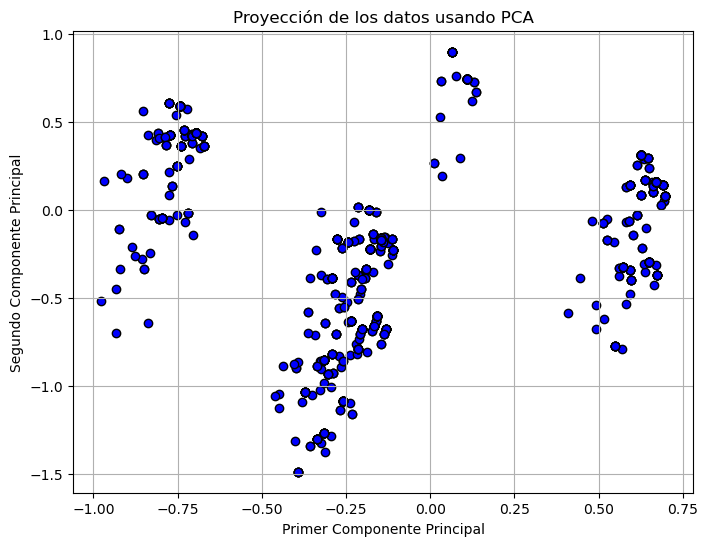

In [118]:
plt.figure(figsize=(8, 6))

# Crear un gráfico de dispersión (scatter plot)
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='k')

# Agregar etiquetas y título
plt.xlabel('Primer Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.title('Proyección de los datos usando PCA')
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [119]:
hierarchical = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X)

In [120]:
# Code obtained from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

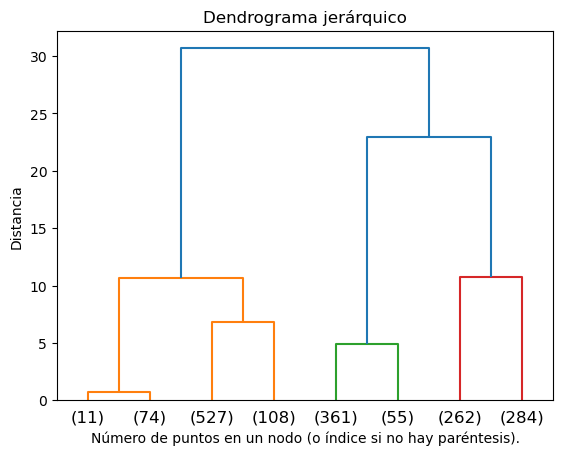

In [121]:
plt.title("Dendrograma jerárquico")
# plot the top three levels of the dendrogram
plot_dendrogram(hierarchical, truncate_mode="level", p=2)
plt.xlabel("Número de puntos en un nodo (o índice si no hay paréntesis).")
plt.ylabel("Distancia")
plt.show()

### Aplicación de NMF

... Describir el proceso de NMF aquí

A continuación crearemos la matriz $V$ que estará compuesta por la combinación de los usuarios con las películas y las calificaciones serán los valores de cada celda. Cada usuario será una observación y cada película una característica. De esta manera tenemos como resultado una matriz $V$ con dimensiones $1682 \times 943$

In [122]:
user_rating_counts = ratings['User ID'].value_counts()
user_rating_counts = user_rating_counts[user_rating_counts > 20]
pd.DataFrame(user_rating_counts).shape

(671, 1)

In [123]:
item_rating_counts = ratings['Item ID'].value_counts()
pd.DataFrame(item_rating_counts).shape

(1626, 1)

In [124]:
# Crear la matriz usuario-película
user_movie_matrix = ratings.pivot_table(columns='User ID', index='Item ID', values='Rating', fill_value=0).reindex(index=range(1, 1683), columns=range(1, 944), fill_value=0)

print('Dimensiones de la matriz usuario-película: ', user_movie_matrix.shape)
user_movie_matrix.head()

Dimensiones de la matriz usuario-película:  (1682, 943)


User ID,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
Item ID,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
